In [1]:
%pip install librosa
import librosa
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
from fastdtw import fastdtw
import joblib
from joblib import Parallel, delayed


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: C:\Users\ifc04\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


KeyboardInterrupt: 

In [ ]:
x1, sr1 = librosa.load('score_midi.mp3',duration=45)
x2, sr2 = librosa.load('performance.mp3', duration=45)

In [ ]:
print(sr1, sr2)

22050 22050


In [ ]:
hop_length = 256
#Compute chroma features from the two input signals
C1_cens = librosa.feature.chroma_cens(x1, sr=sr1, hop_length=hop_length)
C2_cens = librosa.feature.chroma_cens(x2, sr=sr2, hop_length=hop_length)


C:\Users\ifc04\AppData\Local\Temp\ipykernel_1980\3071782792.py:3: FutureWarning: Pass y=[0.         0.         0.         ... 0.09901765 0.14487365 0.13561565] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  C1_cens = librosa.feature.chroma_cens(x1, sr=sr1, hop_length=hop_length)
C:\Users\ifc04\AppData\Local\Temp\ipykernel_1980\3071782792.py:4: FutureWarning: Pass y=[-3.3842517e-13 -4.2703244e-14 -1.8692575e-13 ...  1.5875775e-02
  1.3703901e-02  1.7172195e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  C2_cens = librosa.feature.chroma_cens(x2, sr=sr2, hop_length=hop_length)


In [ ]:
print(C1_cens.shape)
print(C2_cens.shape)

(12, 3876)
(12, 3876)


In [ ]:

#Compute CQT features from the two input signals for visualization
C1_cqt = librosa.cqt(x1, sr=sr1, hop_length=hop_length)
C2_cqt = librosa.cqt(x2, sr=sr2, hop_length=hop_length)

In [ ]:

#Convert to dB scale
C1_cqt_mag = librosa.amplitude_to_db(abs(C1_cqt))
C2_cqt_mag = librosa.amplitude_to_db(abs(C2_cqt))

## DTW

In [ ]:


def dtw_table(x, y, distance=None):
    if distance is None:
        distance = sp.spatial.distance.euclidean
    nx = len(x)
    ny = len(y)
    table = np.zeros((nx+1, ny+1))
    
    # Compute left column separately, i.e. j=0.
    table[1:, 0] = np.inf
        
    # Compute top row separately, i.e. i=0.
    table[0, 1:] = np.inf
        
    # Fill in the rest.
    for i in range(1, nx+1):
        for j in range(1, ny+1):
            d = distance(x[i-1], y[j-1])
            table[i, j] = d + min(table[i-1, j], table[i, j-1], table[i-1, j-1])
    return table



In [ ]:
def dtw(x, y, table):
    i = len(x)
    j = len(y)
    path = [(i, j)]
    while i > 0 or j > 0:
        minval = np.inf
        if table[i-1][j-1] < minval:
            minval = table[i-1, j-1]
            step = (i-1, j-1)
        if table[i-1, j] < minval:
            minval = table[i-1, j]
            step = (i-1, j)
        if table[i][j-1] < minval:
            minval = table[i, j-1]
            step = (i, j-1)
        path.insert(0, step)
        i, j = step
    return np.array(path)

In [ ]:
%%time
#D = dtw_table(C1_cens.T, C2_cens.T, distance=sp.spatial.distance.cosine)

#path = dtw(C1_cens.T, C2_cens.T, D)

#8 minutes

In [ ]:
#Run DTW between pairs of signals:

D = dtw_table(C1_cens.T, C2_cens.T, distance=sp.spatial.distance.cosine)

path = dtw(C1_cens.T, C2_cens.T, D)



In [ ]:
%%time
from scipy.spatial.distance import euclidean
path_fast=fastdtw(C1_cens.T, C2_cens.T, dist=euclidean)

CPU times: total: 672 ms
Wall time: 1.88 s


Evaluate
Listen to the both recordings at the same alignment marker:

In [ ]:
path.shape

NameError: name 'path' is not defined

In [ ]:

i1, i2 = librosa.frames_to_samples(path[113], hop_length=hop_length)
print(i1, i2)


10752 28928


In [ ]:
ipd.Audio(x1[i1:], rate=sr1)
#save to mp3



In [ ]:
ipd.Audio(x2[i2:], rate=sr2)


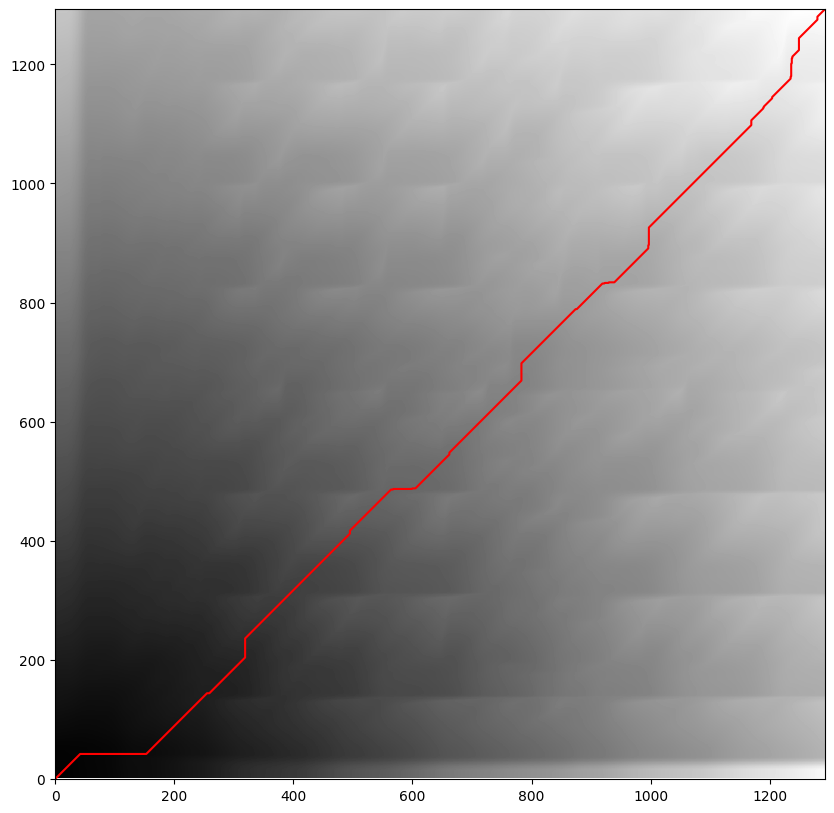

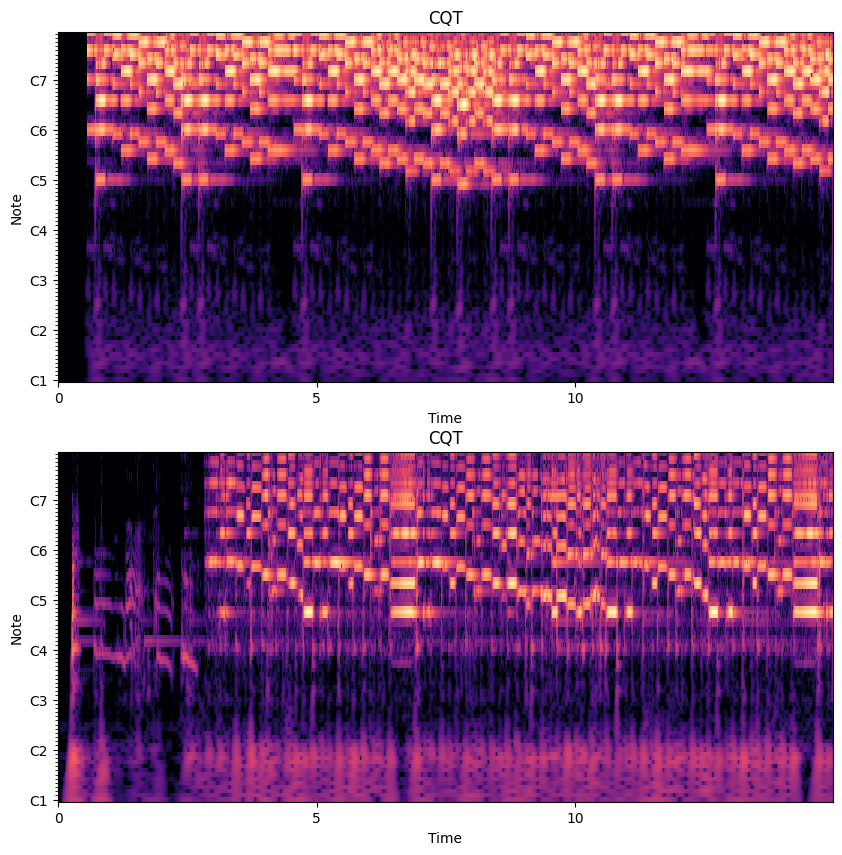

In [ ]:
#Plot D and the path
plt.figure(figsize=(10, 10))
plt.imshow(D, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[:, 1], path[:, 0], 'r')
#Plot CQT features
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
librosa.display.specshow(C1_cqt_mag, sr=sr1, hop_length=hop_length, x_axis='time', y_axis='cqt_note')
plt.title('CQT')
plt.subplot(2, 1, 2)
librosa.display.specshow(C2_cqt_mag, sr=sr2, hop_length=hop_length, x_axis='time', y_axis='cqt_note')
plt.title('CQT')

plt.show()



Text(0.5, 1.0, 'CENS')

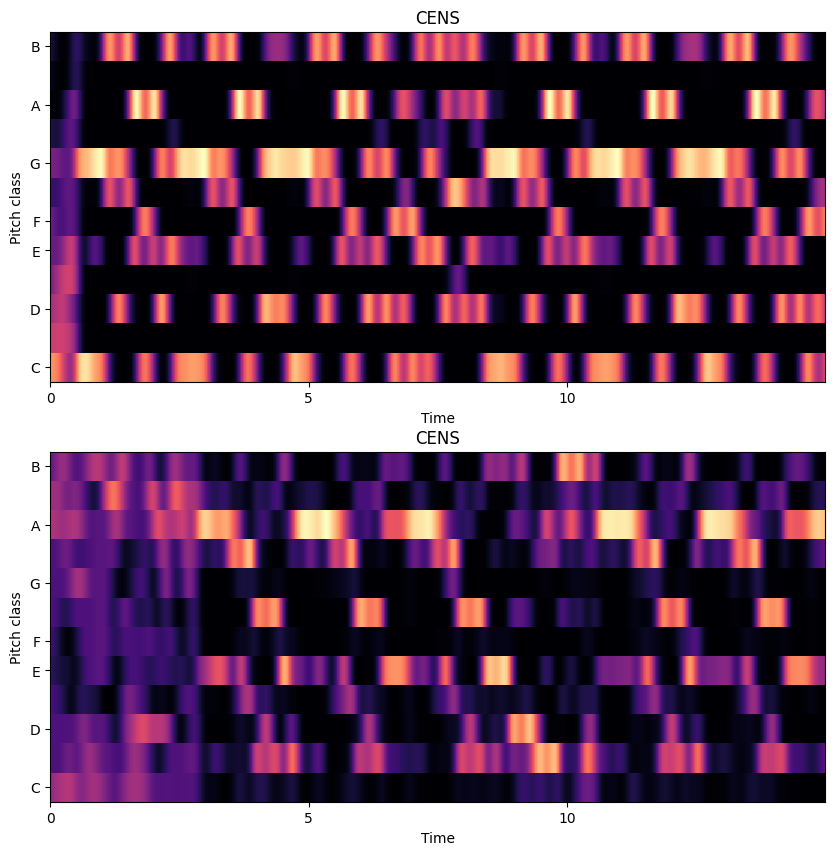

In [ ]:
#plot mag 
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
librosa.display.specshow(C1_cens, sr=sr1, hop_length=hop_length, x_axis='time', y_axis='chroma')
plt.title('CENS')
plt.subplot(2, 1, 2)
librosa.display.specshow(C2_cens, sr=sr2, hop_length=hop_length, x_axis='time', y_axis='chroma')
plt.title('CENS')

In [ ]:
D

array([[0.00000000e+00,            inf,            inf, ...,
                   inf,            inf,            inf],
       [           inf, 2.45632052e-01, 4.93006706e-01, ...,
        6.78187277e+02, 6.78928526e+02, 6.79666258e+02],
       [           inf, 4.95634496e-01, 4.97371554e-01, ...,
        6.78191083e+02, 6.78932326e+02, 6.79670051e+02],
       ...,
       [           inf, 5.38241930e+02, 5.38244331e+02, ...,
        6.93767255e+02, 6.93778085e+02, 6.93790277e+02],
       [           inf, 5.38582105e+02, 5.38584473e+02, ...,
        6.94427610e+02, 6.94438296e+02, 6.94450295e+02],
       [           inf, 5.38925923e+02, 5.38928255e+02, ...,
        6.95101414e+02, 6.95111959e+02, 6.95123766e+02]])

In [ ]:
import pandas as pd
# save path x value as score time and path y value as performance time, changed from ms to s
score_time = path[:, 1] * hop_length / sr1
performance_time = path[:, 0] * hop_length / sr2
#dataframe of score time and performance time
df = pd.DataFrame({'score_time': score_time, 'performance_time': performance_time})
#save as txt file
df.to_csv('path.txt', sep='\t', index=False)


